In [200]:
import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import re
import string
import sys
import tensorflow as tf
from autocorrect import Speller
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from pyspark.sql import Row, functions
from sklearn.manifold import TSNE
from typing import Iterable

In [35]:
sys.path.append("../../")

from src.ingestion.database.reader import *

reader = IngestionReader(
    db_host="127.0.0.1", db_user="postgres",
    db_password="0f21e4cd-44f8-48ab-b112-62030d7f7df1",
    jdbc_driver_path="../../third_party/postgresql-42.5.0.jar")


In [37]:
contents = ReadContents(reader)

# genome_scores = contents.select(["genome_scores"])

# def TakeTagIds(row: Row) -> Iterable[Row]:
#     relevances = json.loads(s=row["genome_scores"])
#     for tag_id, _ in relevances.items():
#         yield Row(tag_id=int(tag_id))


# all_genome_tags = genome_scores.rdd.\
#     flatMap(TakeTagIds).\
#     toDF().\
#     distinct().\
#     sort("tag_id").\
#     cache()

# all_genome_tags.\
#     coalesce(numPartitions=1).\
#     write.\
#         mode(saveMode="overwrite").\
#         csv(path="./dict_genome_score")

# genome_tag_count = all_genome_tags.count()


In [3]:
tmdb_primary_info = contents.select(["id", "tmdb_primary_info"])

def TakeSummary(row: Row) -> Iterable[Row]:
    if row["tmdb_primary_info"] is None:
        return

    info = json.loads(row["tmdb_primary_info"])
    if info is None or info["overview"] is None:
        return
    
    yield Row(id=row["id"], summary=info["overview"])

tmdb_summaries = tmdb_primary_info.rdd.flatMap(TakeSummary).toDF().repartition(numPartitions=32)

In [3]:
nltk.data.path.append("../../third_party/nltk_data")

PUNCT = re.compile(r'[%s\s‐‘’“”–—…]+' % re.escape(string.punctuation))
STOP_WORDS = set(stopwords.words("english"))

def PreprocessCorpus(row: Row) -> Row:
    # if "../../third_party/nltk_data" not in nltk.data.path:
    #     nltk.data.path.append("../../third_party/nltk_data")

    result_list = list()

    stemmer = PorterStemmer()
    speller = Speller()

    # words = nltk.tokenize.word_tokenize(row["summary"])
    words = PUNCT.split(row["summary"])
    for word in words:
        word = word.lower()
        word = speller.autocorrect_word(word)
        if word == "" or word in STOP_WORDS:
            continue

        word = stemmer.stem(word)
        
        result_list.append(word)
    
    return Row(id=row["id"], summary=result_list)


clean_tmdb = tmdb_summaries.rdd.map(PreprocessCorpus).toDF()


clean_tmdb.\
    write.\
    mode(saveMode="overwrite").\
    json(path="./tmdb")


NameError: name 'nltk' is not defined

In [4]:
clean_tmdb = reader.spark_session.read.json(path="tmdb")


def TakeWords(row: Row) -> Iterable[Row]:
    for word in row["summary"]:
        yield Row(word=word)

all_words: DataFrame = clean_tmdb.rdd.\
    flatMap(TakeWords).\
    toDF().\
    distinct().\
    sort("word")

all_words.coalesce(numPartitions=1).\
    write.\
    mode(saveMode="overwrite").\
    csv(path="./dict_word")


In [6]:
clean_tmdb = reader.spark_session.read.json(path="tmdb")

def TermFrequencies(row: Row) -> Iterable[Row]:
    word_freq = dict()
    
    for word in row["summary"]:
        if word not in word_freq:
            word_freq[word] = 1.0
        else:
            word_freq[word] += 1.0
    
    for word in word_freq:
        term_freq = word_freq[word] / len(word_freq)
        yield Row(id=row["id"], term=word, term_freq=term_freq)

term_freqs = clean_tmdb.rdd.flatMap(TermFrequencies).toDF()


In [7]:
from pyspark.sql import Row, functions

doc_count = term_freqs.select(["id"]).distinct().count()
docs_freq = term_freqs.groupBy("term").agg(functions.count_distinct("id"))
docs_freq = docs_freq.withColumn(colName="inv_doc_freq",
                                 col=functions.log2(doc_count / functions.col("count(id)")))
docs_freq = docs_freq.drop("count(id)")

In [149]:
tf_idf = term_freqs.join(other=docs_freq, on=term_freqs["term"] == docs_freq["term"])
tf_idf = tf_idf.drop(docs_freq["term"])

tf_idf = tf_idf.withColumn(colName="tf_idf", col=tf_idf["term_freq"] * tf_idf["inv_doc_freq"])
tf_idf = tf_idf.\
    select(["id", "term", "term_freq", "tf_idf"]).\
    sort(["id", "tf_idf", "term_freq", "term"],
         ascending=[True, False, True])

tf_idf.\
    coalesce(numPartitions=1).\
    write.mode(saveMode="overwrite").\
    csv(path="tf_idf")


In [267]:
weighted_term = tf_idf.\
    groupBy("term").\
    agg(functions.max("tf_idf")).\
    sort("max(tf_idf)", ascending=False)

weighted_term.\
    coalesce(numPartitions=1).\
    write.\
    mode(saveMode="overwrite").\
    csv(path="weighted_term")

In [150]:
word_ind = 0
word_to_ind = dict()
for row in all_words.collect():
    word_to_ind[row["word"]] = word_ind
    word_ind += 1

len(word_to_ind)


33019

In [151]:
content_ids = clean_tmdb.select(["id"]).sort("id").collect()

content_ind = 0
content_id_to_ind = dict()
for row in content_ids:
    content_id_to_ind[row["id"]] = content_ind
    content_ind += 1

len(content_id_to_ind)


57153

In [167]:
from scipy.sparse import coo_matrix
import numpy as np

xs = list()
ys = list()
vs = list()

for row in tf_idf.collect():
    xs.append(content_id_to_ind[row["id"]])
    ys.append(word_to_ind[row["term"]])
    vs.append(row["tf_idf"])

a = coo_matrix((vs, (xs, ys)), dtype=np.float32)
a.shape


(57153, 33019)

In [255]:
from sklearn.decomposition import TruncatedSVD

pca_model = TruncatedSVD(n_components=100)
u = pca_model.fit_transform(a)
print(pca_model.explained_variance_ratio_)
print(np.sum(pca_model.explained_variance_ratio_))


[0.00629219 0.00125379 0.00188341 0.00168053 0.00153348 0.00137602
 0.00135636 0.00126225 0.0012448  0.00120433 0.00116343 0.00115626
 0.00112365 0.00112112 0.00110934 0.00107076 0.00104894 0.00103391
 0.00102049 0.00098573 0.00097294 0.00096683 0.00096257 0.00094297
 0.00092462 0.00090982 0.00090492 0.00089455 0.00088713 0.00087374
 0.00086799 0.00086816 0.00086065 0.0008469  0.00083213 0.00083107
 0.00081857 0.00081093 0.00080895 0.00079881 0.00079316 0.00077991
 0.00077173 0.00076536 0.00076119 0.00075606 0.00075409 0.00074512
 0.00074399 0.00073611 0.00072187 0.00071919 0.00071518 0.00071108
 0.00070529 0.00069694 0.00069332 0.00068979 0.00068678 0.0006817
 0.0006806  0.00067733 0.00067179 0.00066871 0.00066187 0.00066246
 0.0006564  0.0006529  0.00064928 0.00064845 0.00064183 0.0006397
 0.00063646 0.00063117 0.00062861 0.00062907 0.0006241  0.00061695
 0.00061605 0.00061282 0.0006123  0.00060595 0.00060395 0.00059631
 0.00059537 0.0005946  0.00059014 0.00058588 0.00058465 0.000581

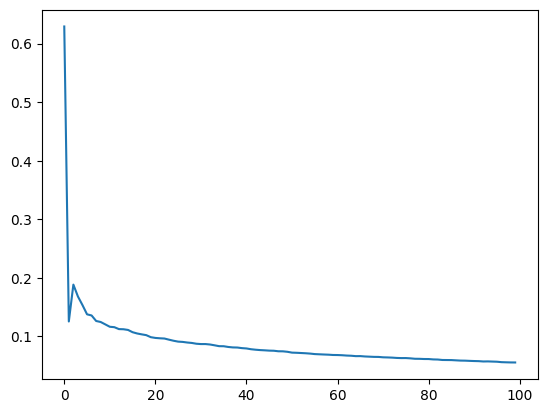

In [256]:
s = pca_model.explained_variance_ratio_
plt.plot(np.arange(stop=s.shape[0]), s*100)



In [170]:
word1 = vh[:, word_to_ind["love"]]
word2 = vh[:, word_to_ind["hate"]]
word3 = vh[:, word_to_ind["ador"]]

def CosineSim(a: np.ndarray, b: np.ndarray) -> np.float32:
    return np.dot(a, b)/(np.sqrt(np.dot(a, a))*np.sqrt(np.dot(b, b)))


x = CosineSim(a=word1, b=word2)
y = CosineSim(a=word1, b=word3)

print(x, y)


0.44395918 0.08689446


In [257]:
genres = contents.select(["id", "genres"]).sort("id")

data_set = clean_tmdb.join(other=genres, on=clean_tmdb["id"] == genres["id"])
data_set = data_set.select([genres["id"], genres["genres"]])

data_count = data_set.count()
data_count


57153

In [258]:
genre_ind = 0
genre_to_ind = dict()

for row in data_set.collect():
    for genre in row["genres"]:
        if genre not in genre_to_ind:
            genre_to_ind[genre] = genre_ind
            genre_ind += 1

genre_count = len(genre_to_ind)
genre_count


20

In [259]:
xs = np.copy(u)
ys = np.zeros(shape=(data_count, genre_count), dtype=np.float32)

for row in data_set.collect():
    c_ind = content_id_to_ind[row["id"]]
    for genre in row["genres"]:
        ys[c_ind, genre_to_ind[genre]] = 1


In [260]:
x_train = xs[:int(data_count*0.8)]
y_train = ys[:int(data_count*0.8)]

x_test = xs[int(data_count*0.8):]
y_test = ys[int(data_count*0.8):]


In [261]:
ra = np.arange(stop=x_train.shape[0])
np.random.shuffle(ra)

tsne = TSNE()
embedded_u = tsne.fit_transform(x_train[ra[:1000], :])
embedded_u.shape


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1000, 2)

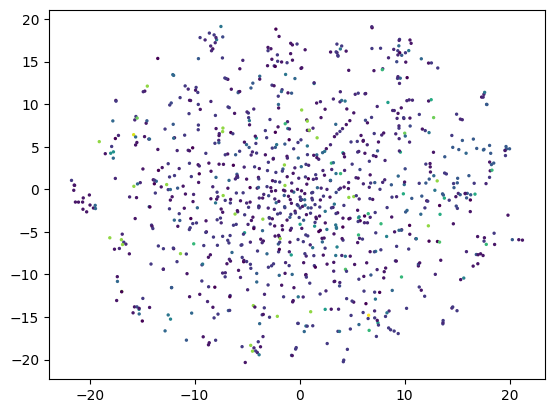

In [262]:
y_train_class = np.zeros(shape=(embedded_u.shape[0]))
for i in range(embedded_u.shape[0]):
    genre = np.nonzero(y_train[ra[i], :])
    y_train_class[i] = genre[0][0]

plt.scatter(x=embedded_u[:, 0], y=embedded_u[:, 1], c=y_train_class, s=2.0)


In [253]:
model = tf.keras.Sequential(
    layers=[tf.keras.layers.InputLayer(input_shape=(x_train.shape[1])),
            tf.keras.layers.Dense(
                units=y_train.shape[1],
                activation=tf.keras.activations.sigmoid), ])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01), 
              loss=tf.keras.losses.binary_crossentropy)
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 20)                20020     
                                                                 
Total params: 20,020
Trainable params: 20,020
Non-trainable params: 0
_________________________________________________________________


In [254]:
model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), epochs=20)

Epoch 1/20
1429/1429 [==============================] - 1s 824us/step - loss: 0.2430 - val_loss: 0.1964
Epoch 2/20
1429/1429 [==============================] - 1s 774us/step - loss: 0.1968 - val_loss: 0.1949
Epoch 3/20
1429/1429 [==============================] - 1s 748us/step - loss: 0.1924 - val_loss: 0.1960
Epoch 4/20
1429/1429 [==============================] - 1s 796us/step - loss: 0.1907 - val_loss: 0.1972
Epoch 5/20
1429/1429 [==============================] - 1s 728us/step - loss: 0.1898 - val_loss: 0.1981
Epoch 6/20
1429/1429 [==============================] - 1s 796us/step - loss: 0.1893 - val_loss: 0.1989
Epoch 7/20
1429/1429 [==============================] - 1s 782us/step - loss: 0.1890 - val_loss: 0.1998
Epoch 8/20
1429/1429 [==============================] - 1s 764us/step - loss: 0.1887 - val_loss: 0.2001
Epoch 9/20
1429/1429 [==============================] - 1s 810us/step - loss: 0.1885 - val_loss: 0.1999
Epoch 10/20
1429/1429 [==============================] - 1s 770u

In [189]:
ypreds = model.predict(x=x_test)
ypreds

358/358 [==============================] - 0s 474us/step


array([[3.57503799e-04, 2.61189193e-01, 8.42848644e-02, ...,
        3.72637878e-04, 4.00217687e-06, 5.75548574e-06],
       [1.17072530e-01, 1.22394547e-01, 1.68427855e-01, ...,
        9.76075884e-03, 2.40285359e-02, 1.71689549e-04],
       [2.60943938e-02, 3.46779257e-01, 1.06998295e-01, ...,
        2.71551199e-02, 1.14048747e-02, 6.37129648e-04],
       ...,
       [7.38335168e-03, 2.92156249e-01, 3.06560576e-01, ...,
        9.30018816e-03, 5.38036088e-03, 1.49444327e-01],
       [3.90650451e-01, 2.70550072e-01, 1.20578073e-01, ...,
        3.77505831e-02, 2.40749260e-03, 1.25722254e-05],
       [3.46731424e-04, 3.46775949e-02, 2.73867369e-01, ...,
        5.32414997e-05, 6.96786738e-05, 6.81853853e-05]], dtype=float32)

In [191]:
y_mean = np.mean(y_train, axis=0)

print("Baseline:", np.mean(tf.metrics.binary_accuracy(y_test, y_mean)))
print("Model:   ", np.mean(tf.metrics.binary_accuracy(y_test, ypreds)))


Baseline: 0.9176143
Model:    0.9229551
